In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from NeuralNetworks import *
from numerical_integration import *
from tqdm import tqdm
from Kepler import *
from Training import *
torch.set_default_dtype(torch.float64)

torch.random.manual_seed(1)
np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [2]:
def initial_condition():
        def sampler():

            H0 = np.random.uniform(-1.5,-1e-3)
            e = np.random.uniform(0.1,0.8)
            a = -1/(2*H0)

            while True:
                H0 = np.random.uniform(-1.5,-1e-3)
                e = np.random.uniform(0.1,0.7)
                a = -1/(2*H0)
                L0 = np.sqrt((e**2-1)/(2*H0))
                x0, y0 = a * (1 - e), 0
                px0 = 0
                py0 = L0/x0

                if py0 > 2.0:
                    continue

                if L0 > 2.0:
                    continue
                
                H = 0.5 * (px0**2 + py0**2) - 1 / np.sqrt(x0**2 + y0**2)
                
                if np.isclose(H, H0,atol=1e-6):  # Use np.isclose for floating-point comparison
                    break
            return np.array([x0, y0, px0, py0]).flatten()
        return sampler()
    

In [8]:
T_max_train = 5
nsamples_train = 100
ntraj_train = 3000
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 1000

sys = KeplerSystem()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

act_1 = PAU()#PAU()
act_2 = nn.Softplus()

epochs = 100

lr = 1e-3

### Symplectic Euler

In [9]:
integrator = "symplectic euler"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train, integrator=integrator)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val, integrator=integrator)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

100%|██████████| 1000/1000 [00:00<00:00, 1032.89it/s]


100%|██████████| 100/100 [1:47:45<00:00, 64.66s/it, epoch=99, loss=5.8e-5]  


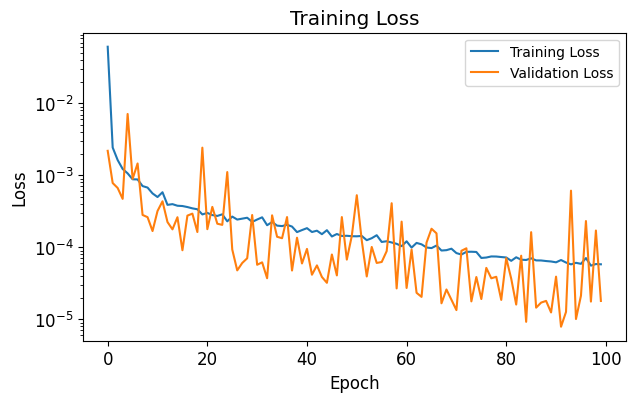

In [11]:
model_symp_eul = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp_eul = torch.optim.Adam(model_symp_eul.parameters(), lr=lr)
model_symp_eul, trainingdetails_symp_eul = train(model = model_symp_eul,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp_eul,shuffle=True, epochs = epochs, name_sys = "Kepler")

100%|██████████| 1/1 [00:00<00:00, 55.34it/s]


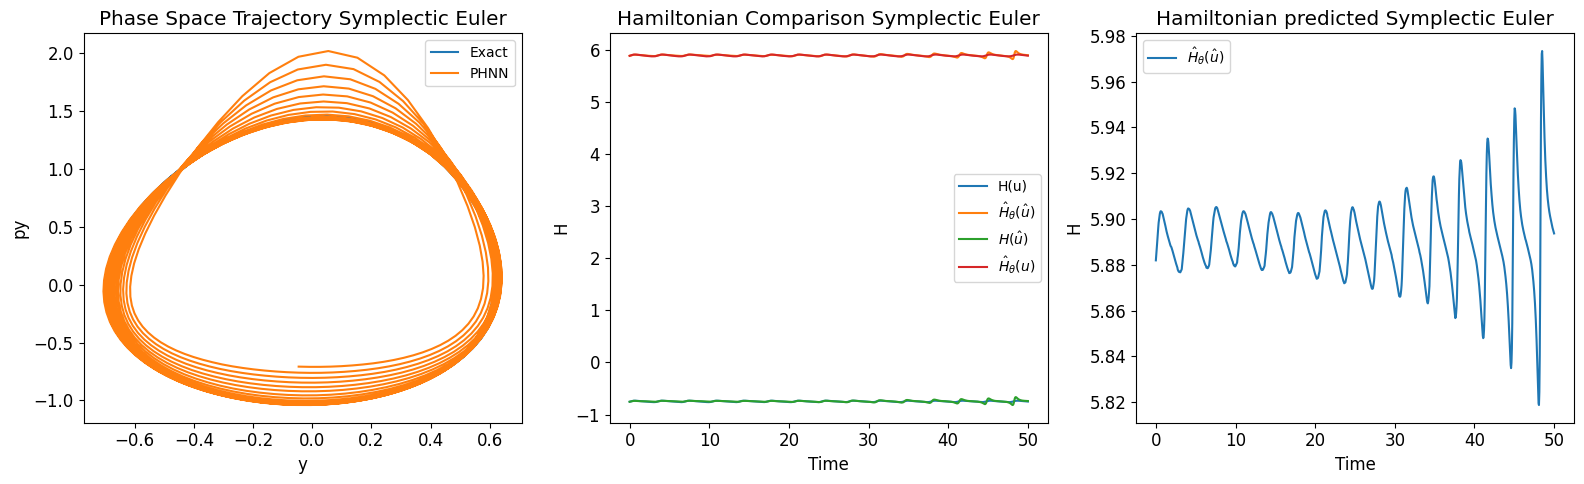

In [27]:
tmax = 5*10
nsamples = 100*10
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic euler"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp_eul.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Euler" )
ax[0].legend()


H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])

t = t_sample.squeeze(0)
u_samples = u_phnn_symp.squeeze(0)
#Computed estimated Hamiltonian from values for prediction
H_symp_nn= torch.tensor([(model_symp_eul.Hamiltonian(u)- model_symp_eul.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])
#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp_eul.Hamiltonian(torch.tensor(u, dtype = torch.float64)) - model_symp_eul.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact.squeeze(0)])


ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Euler")
ax[1].legend()

ax[2].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Euler")
ax[2].legend()

plt.tight_layout() 
plt.show()



## Symplectic Midpoint

In [28]:

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, u0s=u0s_train)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val, integrator=integrator, u0s = u0s_val)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

100%|██████████| 1000/1000 [00:01<00:00, 808.49it/s]


In [ ]:

model_symp = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp = torch.optim.Adam(model_symp.parameters(), lr=lr)
model_symp, trainingdetails_symp = train(model = model_symp,integrator = integrator, train_data = train_data ,val_data = val_data,optimizer = optimizer_symp,shuffle=True, epochs = epochs)


  0%|          | 0/100 [04:10<?, ?it/s, epoch=0, loss=0.0332]

In [ ]:
tmax = 5*10
nsamples = 100*10
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator, u0s = np.array([[0.19772941, -1.29301427,  0.96716548,  0.1479002]]))

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Midpoint")
ax[0].legend()


H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])
t = t_sample.squeeze(0)
u_samples = u_phnn_symp.squeeze(0)
#Computed estimated Hamiltonian from values for prediction
H_symp_nn= torch.tensor([(model_symp.Hamiltonian(u)- model_symp.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])

#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp.Hamiltonian(torch.tensor(u, dtype = torch.float64)) - model_symp.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact.squeeze(0)])


ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred,  label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Midpoint")
ax[1].legend()



ax[2].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()